# Introduction
This notebook is part of model building and experimentation.

Note: If you are reading file from GCS point the environment variable to service account key file as below

In [1]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'C:\Users\sandipto.sanyal\OneDrive - Accenture\Documents\Study materials\self study\app_deployment\gcloud\sandipto-project-1763acaafc53.json'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import numpy as np
import re

In [3]:
zomato_data_path = 'gs://foundation_project2/training_folder/zomato.csv'
df = pd.read_csv(zomato_data_path)

In [4]:
df.sample(n=5)

url  \
7777   https://www.zomato.com/bangalore/amaravati-gra...   
8146   https://www.zomato.com/bangalore/bakers-glove-...   
32314  https://www.zomato.com/bangalore/maiyas-malles...   
4266   https://www.zomato.com/bangalore/srinidhi-saga...   
36276  https://www.zomato.com/bangalore/biggies-burge...   

                                                 address  \
7777   425, K.S.R Court, Ground Floor, 8th Main, 7th ...   
8146               733/A, 10th Main, 4th block Jayanagar   
32314  119/1, 11th Cross, Ground Floor, Srinidhi Comp...   
4266   68, Appareddy Palya, Near ESI Hospital, HAL 2n...   
36276  7/1, G J Complex, 100 Feet Road, Indiranagar, ...   

                           name online_order book_table  rate  votes  \
7777            Amaravati Grand           No         No   3.4      7   
8146              Baker's Glove          Yes         No   3.4      8   
32314                    Maiyas          Yes         No   3.9    291   
4266   Srinidhi Sagar Food Line          Yes         No   3.7    129   
36276   Biggies Burger 'n' More          Yes         No   4.3    195   

                                phone      location            rest_type  \
7777     080 26680307\r\n080 26787777           BTM        Casual Dining   
8146   080 43943777\r\n+91 8073806094     Jayanagar  Bakery, Quick Bites   
32314                    080 40907332  Malleshwaram  Quick Bites, Bakery   
4266                     080 25250408   Indiranagar          Quick Bites   
36276  +91 9986769000\n+91 9986123444   Indiranagar                 Cafe   

                                              dish_liked  \
7777                                                 NaN   
8146                                                 NaN   
32314  Masala Dosa, Akki Rottis, Filter Coffee, Tea, ...   
4266                    Vada, Masala Dosa, Filter Coffee   
36276  Burgers, Mojito, Sea Food, Hot Dog, Crab Burge...   

                                                cuisines   cost  \
7777                        Chinese, Andhra, Mangalorean  550.0   
8146                                    Desserts, Bakery  550.0   
32314  South Indian, North Indian, Chinese, Bakery, D...  300.0   
4266                 South Indian, North Indian, Chinese   40.0   
36276                            Cafe, Burger, Fast Food  400.0   

                                               menu_item listed_in_type  \
7777                                                 NaN       Delivery   
8146                                                 NaN       Delivery   
32314  Rava Idli,  Masala Dosa, Ghee Roast Masala Dos...       Dine-out   
4266   2 Idly and 1 Vada, Rice Bath, Poori, Masala Do...       Delivery   
36276  Grilled Combo Non Veg, Grilled Combo Veg, Smok...       Delivery   

         listed_in_city  
7777                BTM  
8146                BTM  
32314      Malleshwaram  
4266       Brigade Road  
36276  Old Airport Road

# Check distinct values of output variable

In [5]:
df.rate.value_counts().to_dict()

{3.9: 3972,
 3.8: 3873,
 3.7: 3821,
 3.6: 3316,
 4.0: 3183,
 4.1: 2948,
 3.5: 2784,
 3.4: 2476,
 3.3: 2310,
 4.2: 2184,
 3.2: 1873,
 4.3: 1693,
 3.1: 1561,
 4.4: 1147,
 3.0: 1023,
 2.9: 802,
 4.5: 656,
 2.8: 600,
 2.7: 307,
 4.6: 300,
 2.6: 260,
 4.7: 167,
 2.5: 101,
 2.4: 70,
 4.8: 66,
 4.9: 55,
 2.3: 51,
 2.2: 26,
 2.1: 24,
 2.0: 11,
 1.8: 5}

**Observation:** There are many ratings with uncleaned texts we have to manage them

# Feature selection by problem statement
As per our problem statement we will make the feature selection as below for modelling purpose:

| Feature | Comments |
| :- | :- |
| url | Not used URL has nothing to do with ratings |
| address | Raw address is not required as we will focus on location information |
| name | Name has nothing to do with rating |
| online_order | **Required**. We need to model with online_order. Online delivery service plays good role |
| book_table | **Required**. Table booking feature can play good role in ratings |
| rate | **Required**.  Target variable |
| votes | Not selected as new restaurants which will be onboarded will have little or no votes. Cold start problem |
| phone | Not required|
| location | May be required. We are also capturing the info in **listed_in(city)** |
| rest_type | **Required**. Restaurant type might have some effect |
| dish_liked | Not required. New onboarded restaurant will not have this info. |
| cuisines | **Required**. |
| approx_cost(for two people) | **Required**. |
| reviews_list | Not required as of now. Cold start problem. |
| menu_item | **Required**. Requires data cleaning |
| listed_in(type) | **Required**. |
| listed_in(city) | **Required**.  |

# Feature elimination based on problem statement
Below we will select only the features that we think might be useful as per our problem statement

In [6]:
columns_selected = ['online_order',
                    'book_table',
                    'location',
                    'rest_type',
                    'cuisines',
                    'cost',
                    'menu_item',
                    'listed_in_type',
                    'listed_in_city',
                    'rate'
                   ]
df = df[columns_selected]

In [7]:
df.sample(n=10)

online_order book_table               location           rest_type  \
35967          Yes        Yes           New BEL Road                 Pub   
1787           Yes        Yes               JP Nagar       Casual Dining   
32272          Yes         No           Malleshwaram         Quick Bites   
22073          Yes        Yes  Koramangala 6th Block       Casual Dining   
29513           No         No  Koramangala 4th Block                 Bar   
11509           No         No        Electronic City         Quick Bites   
23214           No         No                    BTM         Quick Bites   
26295          Yes         No  Koramangala 7th Block       Casual Dining   
17321           No         No               JP Nagar         Quick Bites   
3986           Yes        Yes          Sarjapur Road  Casual Dining, Pub   

                                                cuisines    cost  \
35967  Continental, Burger, Italian, Pizza, North Ind...  1100.0   
1787                     Continental, Italian, Beverages  1300.0   
32272                              South Indian, Seafood   300.0   
22073                                 American, European  2500.0   
29513                                        Finger Food  1500.0   
11509                                            Chinese   300.0   
23214                South Indian, North Indian, Chinese   300.0   
26295                     North Indian, Mughlai, Biryani   600.0   
17321                  Asian, BBQ, South Indian, Chinese   300.0   
3986   American, Asian, Continental, North Indian, So...  1200.0   

                                               menu_item listed_in_type  \
35967                                                NaN  Pubs and bars   
1787                                                 NaN       Dine-out   
32272  Chicken Kabab, Chicken Ghee Roast, Chicken Chi...       Dine-out   
22073                                                NaN       Delivery   
29513                                                NaN       Dine-out   
11509                                                NaN       Dine-out   
23214                                                NaN       Dine-out   
26295                                                NaN       Delivery   
17321                                                NaN       Dine-out   
3986                                                 NaN  Pubs and bars   

              listed_in_city  rate  
35967           New BEL Road   3.9  
1787       Bannerghatta Road   4.0  
32272           Malleshwaram   4.0  
22073  Koramangala 4th Block   4.3  
29513  Koramangala 7th Block   3.8  
11509        Electronic City   3.1  
23214  Koramangala 4th Block   3.0  
26295  Koramangala 6th Block   2.9  
17321              Jayanagar   3.3  
3986               Bellandur   4.1

**Observation:**
1. cuisines, menu_item, rest_type require count vectorization using ', ' separated values
1. online_order, book_table, listed_in_city, listed_in_type require one hot encoding

# Simple EDA

## Categorical columns

In [8]:
categorical_cols = ['online_order',
                    'book_table',
                    'location',
                    'rest_type',
                    'listed_in_type',
                    'listed_in_city'
                   ]
for col in categorical_cols:
    print('****{}****'.format(col))
    print(df[col].value_counts().to_dict())
    print('-'*5,'NaNs present','-'*5)
    print(df[col].isna().sum())

****online_order****
{'Yes': 27206, 'No': 14459}
----- NaNs present -----
0
****book_table****
{'No': 35361, 'Yes': 6304}
----- NaNs present -----
0
****location****
{'BTM': 3930, 'Koramangala 5th Block': 2319, 'HSR': 2019, 'Indiranagar': 1847, 'JP Nagar': 1717, 'Jayanagar': 1643, 'Whitefield': 1582, 'Marathahalli': 1443, 'Bannerghatta Road': 1235, 'Koramangala 6th Block': 1077, 'Koramangala 7th Block': 1060, 'Brigade Road': 1052, 'Bellandur': 1012, 'Sarjapur Road': 866, 'Koramangala 1st Block': 852, 'Ulsoor': 849, 'Koramangala 4th Block': 841, 'Electronic City': 840, 'MG Road': 811, 'Banashankari': 744, 'Kalyan Nagar': 698, 'Malleshwaram': 642, 'Richmond Road': 612, 'Residency Road': 605, 'Basavanagudi': 595, 'Frazer Town': 570, 'Church Street': 546, 'Brookefield': 545, 'New BEL Road': 508, 'Kammanahalli': 501, 'Lavelle Road': 487, 'Banaswadi': 480, 'Cunningham Road': 475, 'Rajajinagar': 461, 'Domlur': 409, 'Shanti Nagar': 368, 'Old Airport Road': 358, 'St. Marks Road': 343, 'Shivajin

**Observation:** 
1. We can substitute some locations which have very less counts as "Others"
1. rest_type is not a one-to-one mapping. It needs to be handled through count Vectorizer.
1. There can be direct correlation of **listed_in(city)** and **location**. As per our understanding **listed_in(city)** seems to be more drill down of **location**. So for overall view, we can go with **listed_in(city)**. Need to confirm with B'lore people on these. However there are presence of NaNs in the **location** field. So we will use **listed_in(city)** for it has complete information.
1. Fields like **rest_type** contains too many categories which are comma-separated. We need to perform encoding by count vectorization

In [9]:
df.sample(n=5)

online_order book_table               location    rest_type  \
16832           No        Yes              Jayanagar         Cafe   
22406          Yes         No                    BTM         Cafe   
40359           No         No              Bellandur   Food Court   
27512           No         No  Koramangala 5th Block  Quick Bites   
3055           Yes         No              Bellandur         Cafe   

                                           cuisines   cost menu_item  \
16832         Cafe, Chinese, Continental, Fast Food  800.0       NaN   
22406  Cafe, Continental, Pizza, Italian, Beverages  400.0       NaN   
40359                                 Chinese, Thai  400.0       NaN   
27512                         Chinese, North Indian  250.0       NaN   
3055                                Cafe, Fast Food  900.0       NaN   

      listed_in_type         listed_in_city  rate  
16832       Dine-out              Jayanagar   4.2  
22406       Delivery  Koramangala 4th Block   2.9  
40359       Dine-out          Sarjapur Road   2.9  
27512       Dine-out  Koramangala 6th Block   3.5  
3055           Cafes              Bellandur   3.1

**Observation:** So our custom column cleaner is working fine we can drop these original columns

## Numeric columns <a id='n1'>

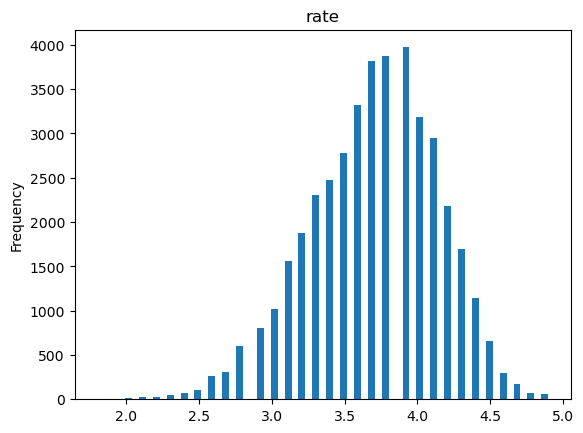

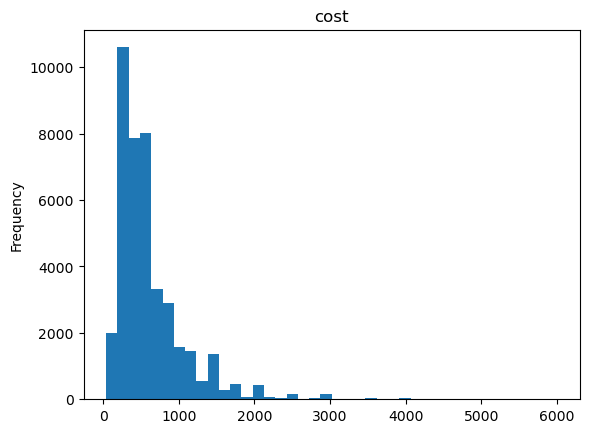

In [10]:
numeric_cols = ['rate',
                'cost'
                ]

col='rate'
df[col].plot.hist(bins=65,title=col)
plt.show()

col='cost'
df[col].plot.hist(bins=40,title=col)
plt.show()

**Observation:**
1. Ratings denote an approximate normal distribution but left skewed.
1. cost being discrete in nature (in 100s). There seems to be a slight bi-modal distribution in cost

# Correlation
Does cost has any correlation with the rating?

In [11]:
df[numeric_cols].corr()

rate      cost
rate  1.000000  0.385183
cost  0.385183  1.000000

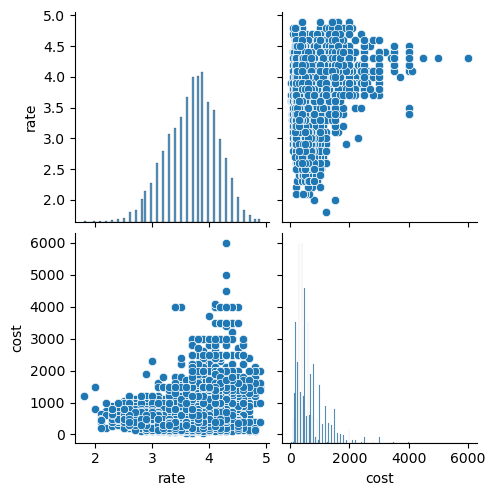

In [12]:
sns.pairplot(data=df[numeric_cols])
plt.show()

**Observation:** Cost has some correlation with ratings. Hence can be put in the model

# Feature selection by statistics
Below we will use statistical measures like:
- One factor ANOVA: To understand whether there is significant level of difference between the output variable and each level of categorical variable

## One Factor ANOVA
Here response variable is rating. We would perform one factor ANOVA a single shot test to understand whether there is significant level of rating across different levels of the given categorical column

- Null hypothesis: Mean rating is same across different levels of the given categorical variable
- Alternate hypothesis: Mean rating is not same across different levels of given categorical variable

**Expectation:** If we are able to reject null hypothesis, that qualifies the particular categorical variable for further modelling.

In [13]:
df.sample(5)

online_order book_table         location           rest_type  \
40834          Yes         No       Whitefield       Casual Dining   
20665          Yes         No     Kammanahalli       Casual Dining   
14268          Yes         No      Indiranagar      Dessert Parlor   
39221          Yes         No  Cunningham Road       Casual Dining   
41306           No         No       Whitefield  Casual Dining, Bar   

                                                cuisines    cost menu_item  \
40834                            European, French, Salad  1500.0       NaN   
20665                      Andhra, North Indian, Chinese   600.0       NaN   
14268  Desserts, Ice Cream, Beverages, Fast Food, San...   500.0       NaN   
39221                  Chinese, Asian, American, Seafood   600.0       NaN   
41306                          North Indian, Continental   800.0       NaN   

      listed_in_type  listed_in_city  rate  
40834       Delivery      Whitefield   3.4  
20665       Dine-out    Kammanahalli   3.8  
14268       Delivery     Indiranagar   4.2  
39221       Dine-out  Residency Road   3.4  
41306       Dine-out      Whitefield   3.7

In [14]:
cols_to_check = ['online_order',
                 'book_table',
                 'rest_type',
                 'listed_in_type',
                 'listed_in_city',
               ]

rate ~ C(online_order)


sum_sq       df           F        PR(>F)
C(online_order)    37.913261      1.0  196.293114  1.697891e-44
Residual         8047.048346  41663.0         NaN           NaN

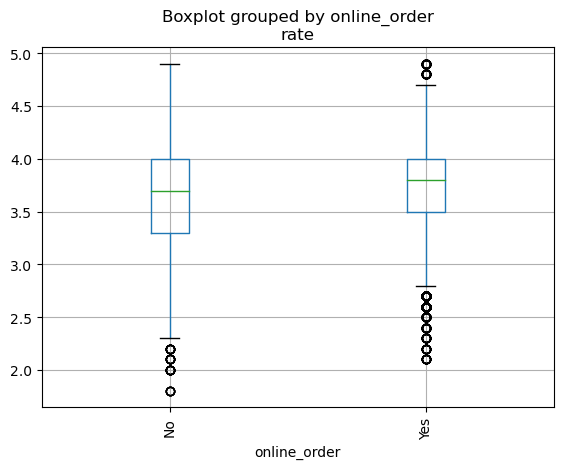

rate ~ C(book_table)


sum_sq       df            F  PR(>F)
C(book_table)  1457.810881      1.0  9164.839798     0.0
Residual       6627.150726  41663.0          NaN     NaN

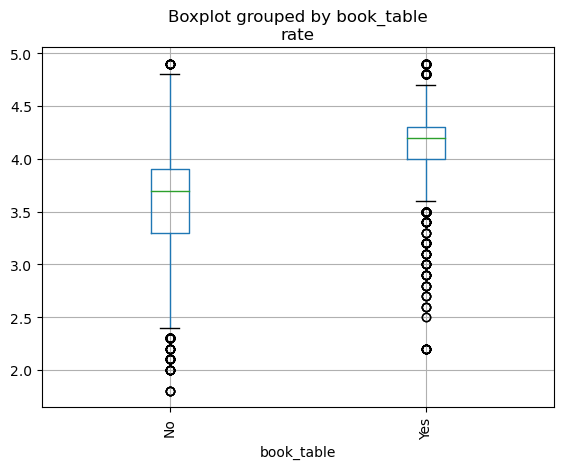

rate ~ C(rest_type)


sum_sq       df           F  PR(>F)
C(rest_type)  1495.273002     86.0  110.235756     0.0
Residual      6534.374263  41429.0         NaN     NaN

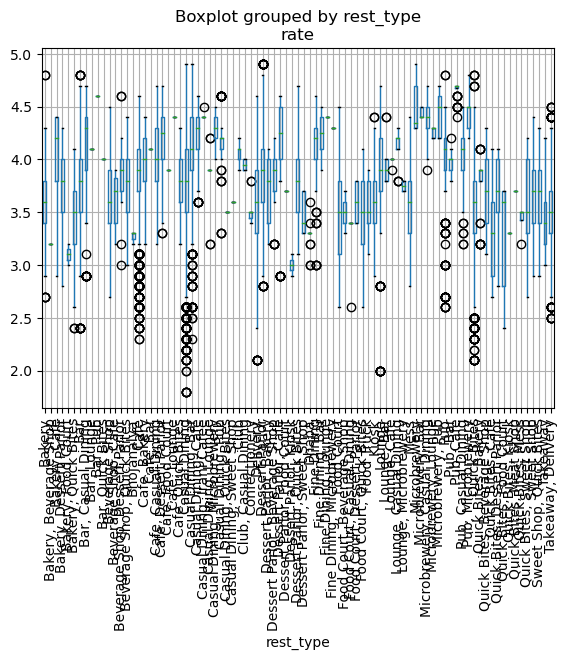

rate ~ C(listed_in_type)


sum_sq       df           F  PR(>F)
C(listed_in_type)   352.878578      6.0  316.866225     0.0
Residual           7732.083030  41658.0         NaN     NaN

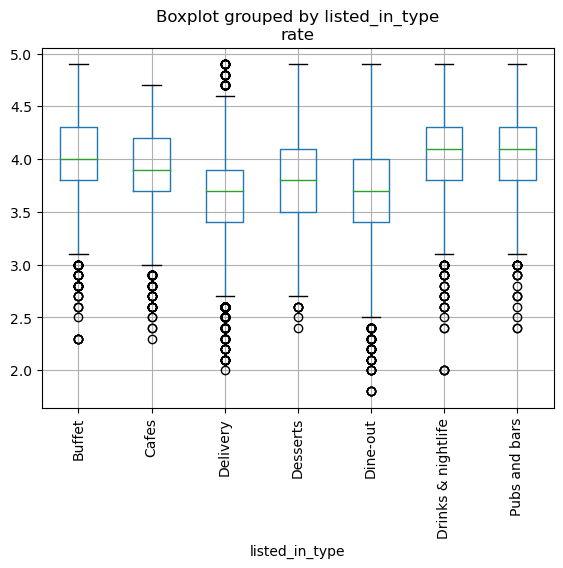

rate ~ C(listed_in_city)


sum_sq       df          F         PR(>F)
C(listed_in_city)   258.837125     29.0  47.483245  3.905529e-267
Residual           7826.124482  41635.0        NaN            NaN

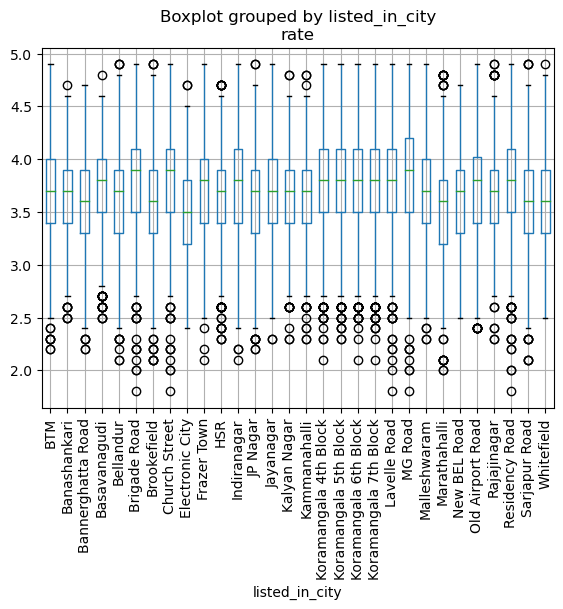

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
for col in cols_to_check:
    formula = f"rate ~ C({col})"
    model = ols(formula, data= df).fit()
    print(formula)
    display(sm.stats.anova_lm(model, typ=2))
    df.boxplot(column='rate', by=col,rot=90)
    plt.show()

**Observation:** From the above statistical analysis we can say that all the chosen variables qualify for modelling.

# Final check of NaN values

In [16]:
df.isna().sum()

online_order          0
book_table            0
location              0
rest_type           149
cuisines             11
cost                247
menu_item         30700
listed_in_type        0
listed_in_city        0
rate                  0
dtype: int64

**Observation:** Thus we have removed all the NaN from the target columns.
1. For **cost** we can perform imputation using KNN Imputer
1. For rest_type,cuisines we will treat NaNs as 'unk' denoting unknown

# Re-arrange the columns
Rearrange the columns such in the following manner as per pre-processig needs:
1. One Hot Encoding columns
1. Count Vectorized Columns
1. Numeric columns

In [17]:
ohe_cols = ['online_order', 
           'book_table', 
           'listed_in_city', 
           'listed_in_type'
          ]
cv_cols = ['cuisines', 
           'rest_type'
          ]
numeric_cols = ['cost']
y = ['rate']
df_rearranged = df[ohe_cols+cv_cols+numeric_cols+y]
df_rearranged.head()

online_order book_table listed_in_city listed_in_type  \
0          Yes        Yes   Banashankari         Buffet   
1          Yes         No   Banashankari         Buffet   
2          Yes         No   Banashankari         Buffet   
3           No         No   Banashankari         Buffet   
4           No         No   Banashankari         Buffet   

                         cuisines            rest_type   cost  rate  
0  North Indian, Mughlai, Chinese        Casual Dining  800.0   4.1  
1     Chinese, North Indian, Thai        Casual Dining  800.0   4.1  
2          Cafe, Mexican, Italian  Cafe, Casual Dining  800.0   3.8  
3      South Indian, North Indian          Quick Bites  300.0   3.7  
4        North Indian, Rajasthani        Casual Dining  600.0   3.8

# Split into Train and Test sets

In [18]:
train_df, test_df = train_test_split(df_rearranged, test_size=0.3)

In [19]:
train_df.shape, test_df.shape

((29165, 8), (12500, 8))

# Pre-processing

In [20]:
X_train = np.empty(shape=(len(train_df),0))
X_test = np.empty(shape=(len(test_df),0))
dict_of_transformers = {}

In [21]:
X_train

array([], shape=(29165, 0), dtype=float64)

## Preprocess for OneHotEncoders

In [22]:
pd.set_option("display.max_columns", 999)

In [23]:
transformer_type = 'one_hot_encoder'
dict_of_transformers[transformer_type] = OneHotEncoder(drop='first', sparse=False)
X = dict_of_transformers[transformer_type].fit_transform(train_df[ohe_cols])
print('Categories found:: ', dict_of_transformers[transformer_type].get_feature_names())
display('Original column', train_df[ohe_cols].head(10))
display('Transformed df:::',pd.DataFrame(data=X, columns=dict_of_transformers[transformer_type].get_feature_names()).head(10))

Categories found::  ['x0_Yes' 'x1_Yes' 'x2_Banashankari' 'x2_Bannerghatta Road'
 'x2_Basavanagudi' 'x2_Bellandur' 'x2_Brigade Road' 'x2_Brookefield'
 'x2_Church Street' 'x2_Electronic City' 'x2_Frazer Town' 'x2_HSR'
 'x2_Indiranagar' 'x2_JP Nagar' 'x2_Jayanagar' 'x2_Kalyan Nagar'
 'x2_Kammanahalli' 'x2_Koramangala 4th Block' 'x2_Koramangala 5th Block'
 'x2_Koramangala 6th Block' 'x2_Koramangala 7th Block' 'x2_Lavelle Road'
 'x2_MG Road' 'x2_Malleshwaram' 'x2_Marathahalli' 'x2_New BEL Road'
 'x2_Old Airport Road' 'x2_Rajajinagar' 'x2_Residency Road'
 'x2_Sarjapur Road' 'x2_Whitefield' 'x3_Cafes' 'x3_Delivery' 'x3_Desserts'
 'x3_Dine-out' 'x3_Drinks & nightlife' 'x3_Pubs and bars']


'Original column'

online_order book_table         listed_in_city listed_in_type
13258          Yes         No                    HSR       Delivery
9202            No        Yes                    BTM  Pubs and bars
16074          Yes         No              Jayanagar       Delivery
8481           Yes         No                    BTM       Dine-out
7356           Yes         No                    BTM       Delivery
12244          Yes         No            Frazer Town       Dine-out
14216          Yes         No            Indiranagar       Delivery
33571           No         No           Marathahalli       Dine-out
26577           No         No  Koramangala 6th Block       Delivery
24272           No         No  Koramangala 5th Block       Delivery

'Transformed df:::'

x0_Yes  x1_Yes  x2_Banashankari  x2_Bannerghatta Road  x2_Basavanagudi  \
0     1.0     0.0              0.0                   0.0              0.0   
1     0.0     1.0              0.0                   0.0              0.0   
2     1.0     0.0              0.0                   0.0              0.0   
3     1.0     0.0              0.0                   0.0              0.0   
4     1.0     0.0              0.0                   0.0              0.0   
5     1.0     0.0              0.0                   0.0              0.0   
6     1.0     0.0              0.0                   0.0              0.0   
7     0.0     0.0              0.0                   0.0              0.0   
8     0.0     0.0              0.0                   0.0              0.0   
9     0.0     0.0              0.0                   0.0              0.0   

   x2_Bellandur  x2_Brigade Road  x2_Brookefield  x2_Church Street  \
0           0.0              0.0             0.0               0.0   
1           0.0              0.0             0.0               0.0   
2           0.0              0.0             0.0               0.0   
3           0.0              0.0             0.0               0.0   
4           0.0              0.0             0.0               0.0   
5           0.0              0.0             0.0               0.0   
6           0.0              0.0             0.0               0.0   
7           0.0              0.0             0.0               0.0   
8           0.0              0.0             0.0               0.0   
9           0.0              0.0             0.0               0.0   

   x2_Electronic City  x2_Frazer Town  x2_HSR  x2_Indiranagar  x2_JP Nagar  \
0                 0.0             0.0     1.0             0.0          0.0   
1                 0.0             0.0     0.0             0.0          0.0   
2                 0.0             0.0     0.0             0.0          0.0   
3                 0.0             0.0     0.0             0.0          0.0   
4                 0.0             0.0     0.0             0.0          0.0   
5                 0.0             1.0     0.0             0.0          0.0   
6                 0.0             0.0     0.0             1.0          0.0   
7                 0.0             0.0     0.0             0.0          0.0   
8                 0.0             0.0     0.0             0.0          0.0   
9                 0.0             0.0     0.0             0.0          0.0   

   x2_Jayanagar  x2_Kalyan Nagar  x2_Kammanahalli  x2_Koramangala 4th Block  \
0           0.0              0.0              0.0                       0.0   
1           0.0              0.0              0.0                       0.0   
2           1.0              0.0              0.0                       0.0   
3           0.0              0.0              0.0                       0.0   
4           0.0              0.0              0.0                       0.0   
5           0.0              0.0              0.0                       0.0   
6           0.0              0.0              0.0                       0.0   
7           0.0              0.0              0.0                       0.0   
8           0.0              0.0              0.0                       0.0   
9           0.0              0.0              0.0                       0.0   

   x2_Koramangala 5th Block  x2_Koramangala 6th Block  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   
5                       0.0                       0.0   
6                       0.0                       0.0   
7                       0.0                       0.0   
8                       0.0                       1.0   
9                       1.0                       0.0   

   x2_Koramangala 7th Block

In [24]:
X_train = np.hstack((X_train,X))
X_test = np.hstack((X_test,dict_of_transformers[transformer_type].transform(test_df[ohe_cols])))
X_train.shape, X_test.shape

((29165, 37), (12500, 37))

## Preprocess Count Vectorizers
The columns which needed to be preprocessed using count vectorizers contains the values in comma separated manner which means restaurants can be of different categories

In [25]:
for col in cv_cols:
    print('\n******', col,'*****')
    # fill na
    train_df[col] = train_df[col].fillna('unk')
    test_df[col] = test_df[col].fillna('unk')
    regex = '\, '
    dict_of_transformers[col] = CountVectorizer(tokenizer=lambda text: re.split(regex,text), binary=True, min_df=10)
    X = dict_of_transformers[col].fit_transform(train_df[col])
    X = X.toarray()
    print('# of Categories found:: ', len(dict_of_transformers[col].get_feature_names()))
    display('Original column', train_df[col].head(10))
    display('Transformed df:::',pd.DataFrame(data=X, columns=dict_of_transformers[col].get_feature_names()).head(10))
    
    X_train = np.hstack((X_train,X))
    X_test_temp = dict_of_transformers[col].transform(test_df[col]).toarray()
    X_test = np.hstack((X_test,X_test_temp))
    print('X_train.shape, X_test.shape=',X_train.shape, X_test.shape)


****** cuisines *****
# of Categories found::  85


<ipython-input-25-a0297af75b1f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col] = train_df[col].fillna('unk')
<ipython-input-25-a0297af75b1f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[col] = test_df[col].fillna('unk')


'Original column'

13258                        Biryani, North Indian
9202                         European, Continental
16074                           Biryani, Fast Food
8481                  North Indian, Chinese, Rolls
7356                                  Pizza, Salad
12244    Arabian, North Indian, Chinese, Beverages
14216                                 South Indian
33571                                 South Indian
26577                                  Continental
24272                               Pizza, Italian
Name: cuisines, dtype: object

'Transformed df:::'

afghan  african  american  andhra  arabian  asian  assamese  awadhi  \
0       0        0         0       0        0      0         0       0   
1       0        0         0       0        0      0         0       0   
2       0        0         0       0        0      0         0       0   
3       0        0         0       0        0      0         0       0   
4       0        0         0       0        0      0         0       0   
5       0        0         0       0        1      0         0       0   
6       0        0         0       0        0      0         0       0   
7       0        0         0       0        0      0         0       0   
8       0        0         0       0        0      0         0       0   
9       0        0         0       0        0      0         0       0   

   bakery  bar food  bbq  bengali  beverages  bihari  biryani  burger  \
0       0         0    0        0          0       0        1       0   
1       0         0    0        0          0       0        0       0   
2       0         0    0        0          0       0        1       0   
3       0         0    0        0          0       0        0       0   
4       0         0    0        0          0       0        0       0   
5       0         0    0        0          1       0        0       0   
6       0         0    0        0          0       0        0       0   
7       0         0    0        0          0       0        0       0   
8       0         0    0        0          0       0        0       0   
9       0         0    0        0          0       0        0       0   

   burmese  cafe  charcoal chicken  chettinad  chinese  coffee  continental  \
0        0     0                 0          0        0       0            0   
1        0     0                 0          0        0       0            1   
2        0     0                 0          0        0       0            0   
3        0     0                 0          0        1       0            0   
4        0     0                 0          0        0       0            0   
5        0     0                 0          0        1       0            0   
6        0     0                 0          0        0       0            0   
7        0     0                 0          0        0       0            0   
8        0     0                 0          0        0       0            1   
9        0     0                 0          0        0       0            0   

   desserts  european  fast food  finger food  french  goan  greek  grill  \
0         0         0          0            0       0     0      0      0   
1         0         1          0            0       0     0      0      0   
2         0         0          1            0       0     0      0      0   
3         0         0          0            0       0     0      0      0   
4         0         0          0            0       0     0      0      0   
5         0         0          0            0       0     0      0      0   
6         0         0          0            0       0     0      0      0   
7         0         0          0            0       0     0      0      0   
8         0         0          0            0       0     0      0      0   
9         0         0          0            0       0     0      0      0   

   gujarati  healthy food  hyderabadi  ice cream  indonesian  iranian  \
0         0             0           0          0           0        0   
1         0             0           0          0           0        0   
2         0             0           0          0           0        0   
3         0             0           0          0           0        0   
4         0             0           0          0           0        0   
5         0             0           0          0           0        0   
6         0             0           0          0           0        0   
7         0             0           0          0           0        0   
8        

X_train.shape, X_test.shape= (29165, 122) (12500, 122)

****** rest_type *****
# of Categories found::  22


<ipython-input-25-a0297af75b1f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col] = train_df[col].fillna('unk')
<ipython-input-25-a0297af75b1f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[col] = test_df[col].fillna('unk')


'Original column'

13258              Delivery
9202     Casual Dining, Pub
16074           Quick Bites
8481            Quick Bites
7356          Casual Dining
12244         Casual Dining
14216    Takeaway, Delivery
33571           Quick Bites
26577           Quick Bites
24272           Quick Bites
Name: rest_type, dtype: object

'Transformed df:::'

bakery  bar  beverage shop  cafe  casual dining  club  confectionery  \
0       0    0              0     0              0     0              0   
1       0    0              0     0              1     0              0   
2       0    0              0     0              0     0              0   
3       0    0              0     0              0     0              0   
4       0    0              0     0              1     0              0   
5       0    0              0     0              1     0              0   
6       0    0              0     0              0     0              0   
7       0    0              0     0              0     0              0   
8       0    0              0     0              0     0              0   
9       0    0              0     0              0     0              0   

   delivery  dessert parlor  dhaba  fine dining  food court  food truck  \
0         1               0      0            0           0           0   
1         0               0      0            0           0           0   
2         0               0      0            0           0           0   
3         0               0      0            0           0           0   
4         0               0      0            0           0           0   
5         0               0      0            0           0           0   
6         1               0      0            0           0           0   
7         0               0      0            0           0           0   
8         0               0      0            0           0           0   
9         0               0      0            0           0           0   

   kiosk  lounge  mess  microbrewery  pub  quick bites  sweet shop  takeaway  \
0      0       0     0             0    0            0           0         0   
1      0       0     0             0    1            0           0         0   
2      0       0     0             0    0            1           0         0   
3      0       0     0             0    0            1           0         0   
4      0       0     0             0    0            0           0         0   
5      0       0     0             0    0            0           0         0   
6      0       0     0             0    0            0           0         1   
7      0       0     0             0    0            1           0         0   
8      0       0     0             0    0            1           0         0   
9      0       0     0             0    0            1           0         0   

   unk  
0    0  
1    0  
2    0  
3    0  
4    0  
5    0  
6    0  
7    0  
8    0  
9    0

X_train.shape, X_test.shape= (29165, 144) (12500, 144)


In [26]:
X_train.shape

(29165, 144)

## Impute Cost
Cost contains NaN values we have to impute them. Note cost will be 144th column in our X matrix

In [27]:
X_train = np.hstack((X_train,train_df.cost.values.reshape(-1,1)))
X_test = np.hstack((X_test,test_df.cost.values.reshape(-1,1)))

In [28]:
dict_of_transformers['imputer'] = KNNImputer(n_neighbors=5)
X_train = dict_of_transformers['imputer'].fit_transform(X_train)
X_test = dict_of_transformers['imputer'].transform(X_test)

## Scale cost
Since cost is on very different scales we need to perform the scaling

In [29]:
dict_of_transformers['cost_scaler'] = StandardScaler()
dict_of_transformers['cost_scaler'].fit(X_train[:,-1].reshape(-1,1))
X_train[:,-1] = dict_of_transformers['cost_scaler'].transform(X_train[:,-1].reshape(-1,1)).reshape(-1,)
X_test[:,-1] = dict_of_transformers['cost_scaler'].transform(X_test[:,-1].reshape(-1,1)).reshape(-1,)

# Perform the modelling

In [30]:
import tensorflow as tf

In [31]:
number_of_hidden_layers = 1
hidden_units = 16
input_layer = tf.keras.Input(shape=(X_train.shape[1],), name='input_layer', dtype='float32')
for h in range(1,number_of_hidden_layers+1):
    if h==1:
        layer = tf.keras.layers.Dense(hidden_units, activation='relu', name='h{}'.format(h))(input_layer)
    else:
        layer = tf.keras.layers.Dense(hidden_units, activation='relu', name='h{}'.format(h))(layer)
outputs = tf.keras.layers.Dense(1, activation='relu', name='output')(layer)

model = tf.keras.Model(inputs=input_layer,outputs=outputs)

## Plot the model

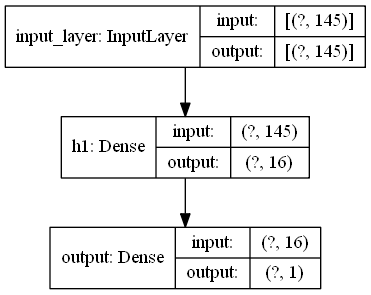

In [32]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,

)

## Compile

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer,loss=loss)

## Train the model

In [34]:
epochs = 50
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10,verbose=1, restore_best_weights=True)]
history = model.fit(x=X_train,y=train_df.rate.values, 
                  batch_size=32,
                  validation_data=(X_test,test_df.rate.values),
                  validation_batch_size=32,
                  epochs=epochs,
                  callbacks=callbacks
                 )

Epoch 1/50
912/912 [==============================] - 1s 2ms/step - loss: 0.3738 - val_loss: 0.1464
Epoch 2/50
912/912 [==============================] - 1s 1ms/step - loss: 0.1431 - val_loss: 0.1512
Epoch 3/50
912/912 [==============================] - 1s 965us/step - loss: 0.1356 - val_loss: 0.1356
Epoch 4/50
912/912 [==============================] - 1s 1ms/step - loss: 0.1315 - val_loss: 0.1267
Epoch 5/50
912/912 [==============================] - 1s 947us/step - loss: 0.1298 - val_loss: 0.1269
Epoch 6/50
912/912 [==============================] - 1s 1ms/step - loss: 0.1270 - val_loss: 0.1224
Epoch 7/50
912/912 [==============================] - 1s 969us/step - loss: 0.1259 - val_loss: 0.1199
Epoch 8/50
912/912 [==============================] - 1s 1ms/step - loss: 0.1229 - val_loss: 0.1184
Epoch 9/50
912/912 [==============================] - 1s 987us/step - loss: 0.1209 - val_loss: 0.1181
Epoch 10/50
912/912 [==============================] - 1s 942us/step - loss: 0.1204 - val_lo

## Plot the model training history

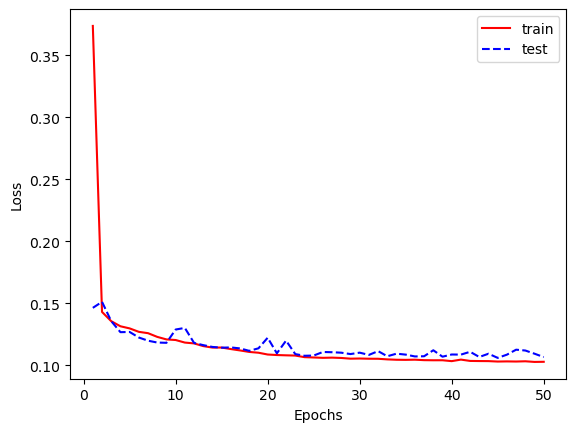

In [35]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_list = np.arange(1,len(train_loss)+1,1)
plt.plot(epoch_list,train_loss,'-r',label='train')
plt.plot(epoch_list,val_loss,'--b', label='test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Perform sample prediction and final model evaluation

In [36]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test).reshape(-1,)
y_pred = np.round(y_pred,decimals=1)
y_test = test_df.rate.values.reshape(-1,)
print('R2: ', r2_score(y_true=y_test,y_pred=y_pred))

R2:  0.44832529053454495


# Perform 5 Fold Cross Validation

In [80]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)
cvscores = []
X = X_train
Y =  train_df.rate.values
for train, test in kfold.split(X, Y):
  # create model
    input_layer = tf.keras.Input(shape=(X_train.shape[1],), name='input_layer', dtype='float32')
    h1 = tf.keras.layers.Dense(16, activation='relu', name='h1')(input_layer)
    outputs = tf.keras.layers.Dense(1, activation='relu', name='output')(h1)
    model = tf.keras.Model(inputs=input_layer,outputs=outputs)
    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(optimizer=optimizer,loss=loss)
    # Fit the model
    epochs = 50
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=10,verbose=1, restore_best_weights=True)]
    history = model.fit(x=X_train,y=train_df.rate.values, 
                      batch_size=32,
                      validation_data=(X_test,test_df.rate.values),
                      validation_batch_size=32,
                      epochs=epochs,
                      callbacks=callbacks,
                        verbose=0
                     )
    # evaluate the model
    
    y_pred = model.predict(X_test).reshape(-1,)
    y_pred = np.round(y_pred,decimals=1)
    y_test = test_df.rate.values.reshape(-1,)
    r2 = r2_score(y_true=y_test,y_pred=y_pred)
    print('Pseudo R2: ', r2)
    cvscores.append(r2 * 100)

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Pseudo R2:  0.43913831878279175
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Pseudo R2:  0.429077240262006
Pseudo R2:  0.4010714403592268
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Pseudo R2:  0.44942815740392994
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Pseudo R2:  0.4238709022539099


In [81]:
import numpy as np
print('Mean R2: {}; Std. dev: {}'.format(np.mean(cvscores)/100,np.std(cvscores)/100))

Mean R2: 0.42851721181237296; Std. dev: 0.01628034246473907


# Model explainability

In [82]:
# !pip install lime

In [37]:
import lime
import lime.lime_tabular

In [38]:
train_df.sample(5)

online_order book_table         listed_in_city listed_in_type  \
28188          Yes        Yes  Koramangala 7th Block       Delivery   
27988          Yes         No  Koramangala 7th Block       Delivery   
29167           No         No  Koramangala 7th Block       Desserts   
18053           No         No               JP Nagar       Delivery   
25673           No         No  Koramangala 6th Block          Cafes   

                             cuisines       rest_type   cost  rate  
28188                    North Indian   Casual Dining  700.0   4.2  
27988                    North Indian     Quick Bites  500.0   4.0  
29167  Ice Cream, Desserts, Beverages  Dessert Parlor  400.0   4.3  
18053                Bakery, Desserts          Bakery  350.0   3.9  
25673               Cafe, Continental            Cafe  600.0   4.1

In [39]:
dict_of_transformers

{'one_hot_encoder': OneHotEncoder(drop='first', sparse=False),
 'cuisines': CountVectorizer(binary=True, min_df=10,
                 tokenizer=<function <lambda> at 0x000002110739A670>),
 'rest_type': CountVectorizer(binary=True, min_df=10,
                 tokenizer=<function <lambda> at 0x0000021168BAE550>),
 'imputer': KNNImputer(),
 'cost_scaler': StandardScaler()}

## Recreate the features of our data

### One Hot Encodings

In [40]:
features = dict_of_transformers['one_hot_encoder'].get_feature_names()
features = [re.sub('x0_','online_order_', element) for element in features]
features = [re.sub('x1_','book_table_', element) for element in features]
features = [re.sub('x2_','listed_in_city_', element) for element in features]
features = [re.sub('x3_','listed_in_type_', element) for element in features]

In [41]:
len(features)

37

### Count Vectorizers

In [42]:
features += ['cuisines_'+element for element in dict_of_transformers['cuisines'].get_feature_names()]
features += ['rest_type_'+element for element in dict_of_transformers['rest_type'].get_feature_names()]

In [43]:
len(features)

144

### Cost

In [44]:
features += ['cost']

In [45]:
len(features)

145

In [46]:
X_train.shape

(29165, 145)

## Create the Explainer

In [47]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
                                                   feature_names=features, 
                                                   class_names=['rate'],
                                                   verbose=True, 
                                                   mode='regression')

## Get the explainer for a sample

'Restaurant features: '

online_order                                               No
book_table                                                 No
listed_in_city                                       JP Nagar
listed_in_type                                       Desserts
cuisines          South Indian, Mithai, Chinese, North Indian
rest_type                           Casual Dining, Sweet Shop
cost                                                    400.0
rate                                                      3.6
Name: 18380, dtype: object

Intercept 4.845289552075681
Prediction_local [3.62910887]
Right: 3.429011


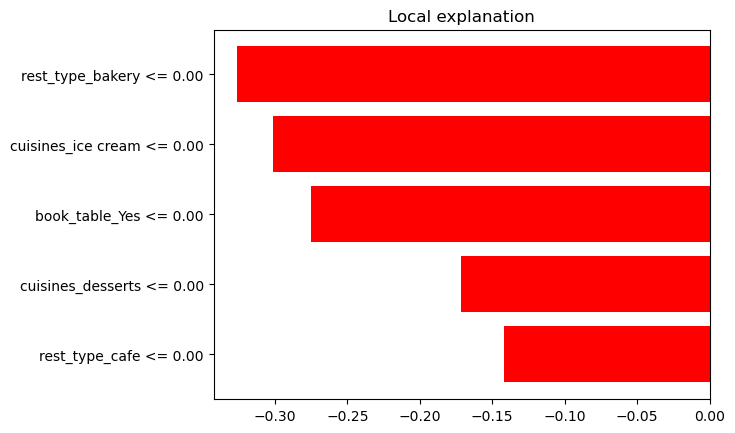

In [48]:
i = np.random.randint(low=0,high=len(X_test)-1)
display('Restaurant features: ', test_df.iloc[i,:])
exp = explainer.explain_instance(X_test[i], model.predict, num_features=5)
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()

## Get explainer for random records which had > mean + 3 std. dev. predicted ratings

'Restaurant features: '

online_order                         No
book_table                          Yes
listed_in_city    Koramangala 5th Block
listed_in_type       Drinks & nightlife
cuisines          European, Continental
rest_type            Casual Dining, Pub
cost                             1800.0
rate                                4.6
Name: 25499, dtype: object

Intercept 4.4209649595805995
Prediction_local [3.87179042]
Right: 4.867597


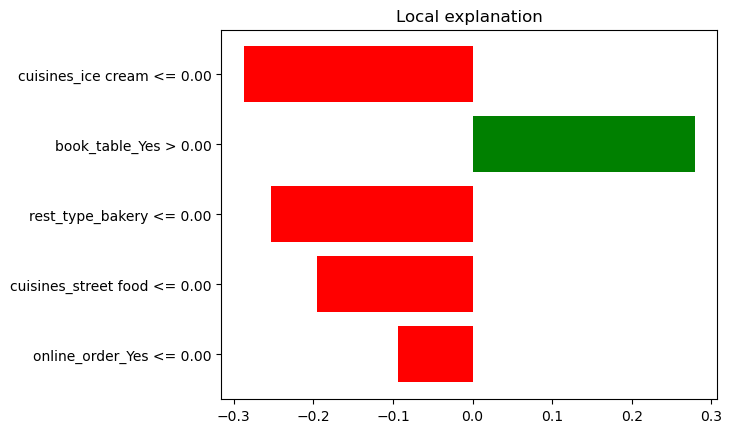

In [49]:
X_filtered = X_test[y_pred >= np.mean(y_pred)+3*np.std(y_pred)]
df_filtered = test_df[y_pred >= np.mean(y_pred)+3*np.std(y_pred)]
i = np.random.randint(low=0,high=len(X_filtered)-1)
display('Restaurant features: ', df_filtered.iloc[i,:])
exp = explainer.explain_instance(X_filtered[i], model.predict, num_features=5)
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()

**Observation:** So majorly we can see that for any particular restaurant what features are attributing to the positivity of the rating and what features are attributing to the make the score lesser.

## Get explainer for random records which had < mean - 3 std. dev. predicted ratings

'Restaurant features: '

online_order                              No
book_table                                No
listed_in_city         Koramangala 7th Block
listed_in_type                      Desserts
cuisines          Bakery, Fast Food, Italian
rest_type                Bakery, Quick Bites
cost                                   600.0
rate                                     2.7
Name: 29215, dtype: object

Intercept 4.4952318887977505
Prediction_local [3.5278174]
Right: 2.789388


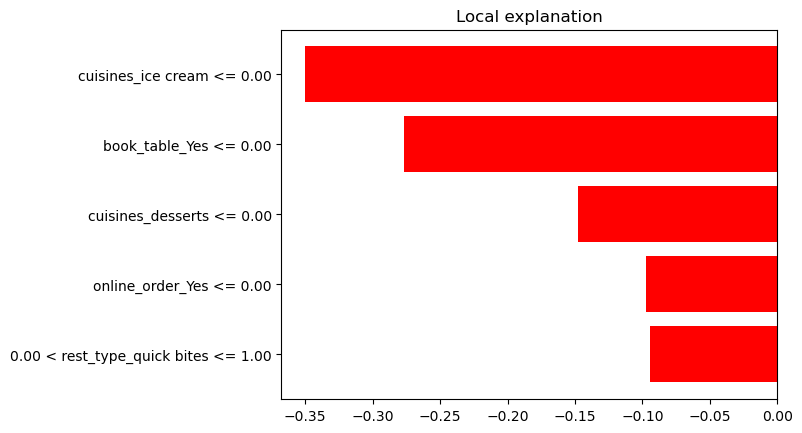

In [50]:
X_filtered = X_test[y_pred <= np.mean(y_pred)-3*np.std(y_pred)]
df_filtered = test_df[y_pred <= np.mean(y_pred)-3*np.std(y_pred)]
i = np.random.randint(low=0,high=len(X_filtered)-1)
display('Restaurant features: ', df_filtered.iloc[i,:])
exp = explainer.explain_instance(X_filtered[i], model.predict, num_features=5)
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()